In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import copy
import warnings
warnings.filterwarnings('ignore')

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device : {device}")
print(f"   GPU Name     : {torch.cuda.get_device_name(0)}")
print(f"   VRAM         : {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


✅ Using device : cuda
   GPU Name     : NVIDIA GeForce RTX 3050 6GB Laptop GPU
   VRAM         : 6.0 GB


In [2]:
# ============================================================
# TRAINING CONFIG
# ============================================================
PROCESSED_DIR = Path("../datasets/processed")
MODELS_DIR    = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

BATCH_SIZE    = 32       # RTX 3050 6GB ke liye safe
NUM_EPOCHS    = 25       # Enough for convergence
LEARNING_RATE = 0.001
NUM_WORKERS   = 4        # Data loading threads
IMG_SIZE      = 224      # EfficientNet standard

# Class count
train_dir = PROCESSED_DIR / "train"
NUM_CLASSES = len(list(train_dir.iterdir()))

print("=" * 45)
print("   TRAINING CONFIGURATION")
print("=" * 45)
print(f"   Batch Size    : {BATCH_SIZE}")
print(f"   Epochs        : {NUM_EPOCHS}")
print(f"   Learning Rate : {LEARNING_RATE}")
print(f"   Image Size    : {IMG_SIZE}x{IMG_SIZE}")
print(f"   Num Classes   : {NUM_CLASSES}")
print(f"   Device        : {device}")
print("=" * 45)


   TRAINING CONFIGURATION
   Batch Size    : 32
   Epochs        : 25
   Learning Rate : 0.001
   Image Size    : 224x224
   Num Classes   : 96
   Device        : cuda


In [3]:
# Training transforms — augmentation included
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

# Val + Test transforms — NO augmentation (sirf normalize)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transforms ready!")
print(f"   Train : Resize + Flip + Rotate + ColorJitter + Normalize")
print(f"   Val   : Resize + Normalize only")


✅ Transforms ready!
   Train : Resize + Flip + Rotate + ColorJitter + Normalize
   Val   : Resize + Normalize only


In [4]:
# Datasets load karo
train_dataset = datasets.ImageFolder(
    root=PROCESSED_DIR / "train",
    transform=train_transforms
)
val_dataset = datasets.ImageFolder(
    root=PROCESSED_DIR / "val",
    transform=val_transforms
)
test_dataset = datasets.ImageFolder(
    root=PROCESSED_DIR / "test",
    transform=val_transforms
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True    # Faster GPU transfer
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Class names save karo
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

# Save class names (FastAPI me kaam aayega)
with open(MODELS_DIR / "class_names.json", "w") as f:
    json.dump(class_names, f, indent=2)

print("✅ Datasets loaded!")
print(f"   Train   : {len(train_dataset):,} images, {len(train_loader)} batches")
print(f"   Val     : {len(val_dataset):,} images, {len(val_loader)} batches")
print(f"   Test    : {len(test_dataset):,} images, {len(test_loader)} batches")
print(f"   Classes : {len(class_names)}")
print(f"\n✅ class_names.json saved → {MODELS_DIR / 'class_names.json'}")


✅ Datasets loaded!
   Train   : 61,766 images, 1931 batches
   Val     : 7,719 images, 242 batches
   Test    : 7,742 images, 242 batches
   Classes : 96

✅ class_names.json saved → ..\models\class_names.json


In [5]:
def build_model(num_classes, device):
    # Pretrained EfficientNetB0 load karo
    model = models.efficientnet_b0(
        weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
    )
    
    # Feature extractor freeze karo (pehle sirf top layers train honge)
    for param in model.parameters():
        param.requires_grad = False
    
    # Custom classification head replace karo
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(512, num_classes)
    )
    
    return model.to(device)

model = build_model(NUM_CLASSES, device)

# Model summary
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ EfficientNetB0 model ready!")
print(f"   Total params     : {total_params:,}")
print(f"   Trainable params : {trainable_params:,}")
print(f"   Frozen params    : {total_params - trainable_params:,}")
print(f"\n   Architecture:")
print(f"   ImageNet EfficientNetB0 → Dropout(0.4)")
print(f"   → Linear(1280→512) → ReLU → Dropout(0.3)")
print(f"   → Linear(512→{NUM_CLASSES})")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\LOQ/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:05<00:00, 3.65MB/s]


✅ EfficientNetB0 model ready!
   Total params     : 4,712,668
   Trainable params : 705,120
   Frozen params    : 4,007,548

   Architecture:
   ImageNet EfficientNetB0 → Dropout(0.4)
   → Linear(1280→512) → ReLU → Dropout(0.3)
   → Linear(512→96)


In [6]:
# Class imbalance handle karne ke liye class weights
class_counts = [
    len(list((PROCESSED_DIR / "train" / cls).iterdir()))
    for cls in class_names
]
total_samples = sum(class_counts)
class_weights = torch.FloatTensor(
    [total_samples / (len(class_names) * count) for count in class_counts]
).to(device)

# Loss function (weighted)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (sirf trainable params)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # LR half ho jaayega
    patience=3,      # 3 epochs no improvement pe reduce
    verbose=True
)

print("✅ Training components ready!")
print(f"   Loss      : CrossEntropyLoss (weighted)")
print(f"   Optimizer : Adam (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"   Scheduler : ReduceLROnPlateau (patience=3, factor=0.5)")


✅ Training components ready!
   Loss      : CrossEntropyLoss (weighted)
   Optimizer : Adam (lr=0.001, weight_decay=1e-4)
   Scheduler : ReduceLROnPlateau (patience=3, factor=0.5)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss"  : [], "val_acc"  : []
    }
    
    best_val_acc = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    
    print("=" * 65)
    print(" TRAINING STARTED")
    print("=" * 65)
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # ── TRAIN PHASE ──────────────────────────────────────
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss    += loss.item()
            _, predicted   = outputs.max(1)
            train_total   += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            # Progress print every 100 batches
            if (batch_idx + 1) % 100 == 0:
                print(f"  Epoch {epoch+1}/{num_epochs} "
                      f"| Batch {batch_idx+1}/{len(train_loader)} "
                      f"| Loss: {loss.item():.4f}")
        
        # ── VALIDATION PHASE ──────────────────────────────────
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs        = model(images)
                loss           = criterion(outputs, labels)
                
                val_loss    += loss.item()
                _, predicted = outputs.max(1)
                val_total   += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # ── METRICS CALCULATE ─────────────────────────────────
        t_loss = train_loss / len(train_loader)
        t_acc  = 100 * train_correct / train_total
        v_loss = val_loss / len(val_loader)
        v_acc  = 100 * val_correct / val_total
        
        history["train_loss"].append(t_loss)
        history["train_acc"].append(t_acc)
        history["val_loss"].append(v_loss)
        history["val_acc"].append(v_acc)
        
        scheduler.step(v_loss)
        
        epoch_time = time.time() - epoch_start
        
        # ── BEST MODEL SAVE ───────────────────────────────────
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                MODELS_DIR / "best_model.pth"
            )
            saved = "✅ SAVED"
        else:
            saved = ""
        
        print(f"\nEpoch {epoch+1:2}/{num_epochs} "
              f"| Train Loss: {t_loss:.4f} Acc: {t_acc:.2f}% "
              f"| Val Loss: {v_loss:.4f} Acc: {v_acc:.2f}% "
              f"| {epoch_time:.0f}s {saved}")
        print("-" * 65)
    
    # Best weights restore karo
    model.load_state_dict(best_model_weights)
    
    print(f"\n🏆 Best Val Accuracy : {best_val_acc:.2f}%")
    print(f"✅ Best model saved  : {MODELS_DIR / 'best_model.pth'}")
    
    return model, history

# ── TRAINING SHURU KARO ───────────────────────────────────────
model, history = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, scheduler,
    NUM_EPOCHS
)


 TRAINING STARTED
  Epoch 1/25 | Batch 100/1931 | Loss: 3.4635
  Epoch 1/25 | Batch 200/1931 | Loss: 2.2441
  Epoch 1/25 | Batch 300/1931 | Loss: 2.0120
  Epoch 1/25 | Batch 400/1931 | Loss: 1.7371
  Epoch 1/25 | Batch 500/1931 | Loss: 0.8778
  Epoch 1/25 | Batch 600/1931 | Loss: 2.0808
  Epoch 1/25 | Batch 700/1931 | Loss: 1.3906
  Epoch 1/25 | Batch 800/1931 | Loss: 1.5162
  Epoch 1/25 | Batch 900/1931 | Loss: 0.9227
  Epoch 1/25 | Batch 1000/1931 | Loss: 1.5036
  Epoch 1/25 | Batch 1100/1931 | Loss: 1.4020
  Epoch 1/25 | Batch 1200/1931 | Loss: 0.7515
  Epoch 1/25 | Batch 1300/1931 | Loss: 0.8173
  Epoch 1/25 | Batch 1400/1931 | Loss: 1.0594
  Epoch 1/25 | Batch 1500/1931 | Loss: 1.6137
  Epoch 1/25 | Batch 1600/1931 | Loss: 1.4151
  Epoch 1/25 | Batch 1700/1931 | Loss: 0.9841
  Epoch 1/25 | Batch 1800/1931 | Loss: 1.5022
  Epoch 1/25 | Batch 1900/1931 | Loss: 1.0670

Epoch  1/25 | Train Loss: 1.6059 Acc: 65.43% | Val Loss: 0.5881 Acc: 79.89% | 169s ✅ SAVED
-------------------------

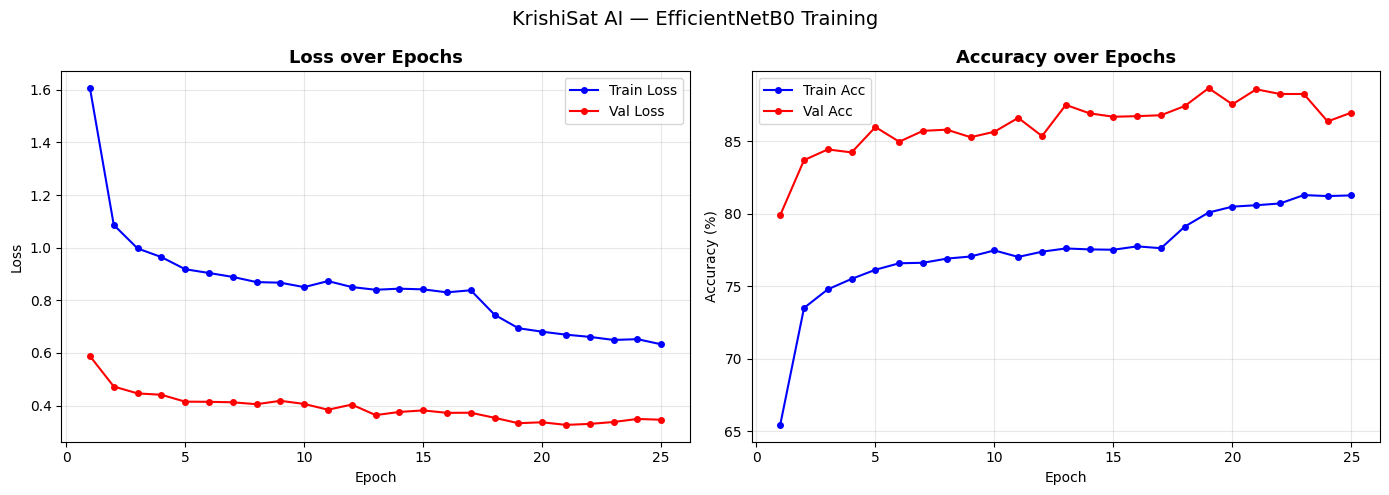

✅ Training graph saved!
   Final Train Acc : 81.26%
   Final Val Acc   : 86.97%
   Best Val Acc    : 88.65%


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history["train_loss"]) + 1)

# Loss graph
ax1.plot(epochs, history["train_loss"], 'b-o', label='Train Loss', markersize=4)
ax1.plot(epochs, history["val_loss"],   'r-o', label='Val Loss',   markersize=4)
ax1.set_title("Loss over Epochs", fontsize=13, fontweight='bold')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy graph
ax2.plot(epochs, history["train_acc"], 'b-o', label='Train Acc', markersize=4)
ax2.plot(epochs, history["val_acc"],   'r-o', label='Val Acc',   markersize=4)
ax2.set_title("Accuracy over Epochs", fontsize=13, fontweight='bold')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle("KrishiSat AI — EfficientNetB0 Training", fontsize=14)
plt.tight_layout()
plt.savefig("training_history.png", dpi=150)
plt.show()

print(f"✅ Training graph saved!")
print(f"   Final Train Acc : {history['train_acc'][-1]:.2f}%")
print(f"   Final Val Acc   : {history['val_acc'][-1]:.2f}%")
print(f"   Best Val Acc    : {max(history['val_acc']):.2f}%")


In [9]:
# Training history JSON me save karo
with open(MODELS_DIR / "training_history.json", "w") as f:
    json.dump(history, f, indent=2)

# Model info save karo
model_info = {
    "architecture"    : "EfficientNetB0",
    "num_classes"     : NUM_CLASSES,
    "img_size"        : IMG_SIZE,
    "batch_size"      : BATCH_SIZE,
    "epochs_trained"  : NUM_EPOCHS,
    "best_val_acc"    : max(history["val_acc"]),
    "train_dataset"   : len(train_dataset),
    "class_names_file": "class_names.json"
}

with open(MODELS_DIR / "model_info.json", "w") as f:
    json.dump(model_info, f, indent=2)

print("✅ All files saved!")
print(f"\n   📁 models/")
print(f"      best_model.pth         ← Trained weights")
print(f"      class_names.json       ← 96 class names")
print(f"      training_history.json  ← Loss/acc per epoch")
print(f"      model_info.json        ← Model metadata")
print(f"\n   Next → 04_model_evaluation.ipynb (Day 5)")


✅ All files saved!

   📁 models/
      best_model.pth         ← Trained weights
      class_names.json       ← 96 class names
      training_history.json  ← Loss/acc per epoch
      model_info.json        ← Model metadata

   Next → 04_model_evaluation.ipynb (Day 5)


In [10]:
# Notebook me ek new cell banao aur run karo
import torch
torch.cuda.empty_cache()
print("✅ GPU memory cleared!")


✅ GPU memory cleared!


In [12]:
print("=" * 55)
print(" PHASE 2 — FINE TUNING")
print("=" * 55)

# Best model reload karo
model.load_state_dict(
    torch.load(MODELS_DIR / "best_model.pth", map_location=device)
)
model = model.to(device)

# Konse layers hain total — count karo
all_params = list(model.named_parameters())
total_layers = len(all_params)
print(f"Total parameter groups : {total_layers}")

# Last 30 layers unfreeze karo
unfreeze_from = total_layers - 30

for i, (name, param) in enumerate(model.named_parameters()):
    if i >= unfreeze_from:
        param.requires_grad = True
    # Classifier already trainable hai — ensure karo
    if "classifier" in name:
        param.requires_grad = True

# Count trainable params
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"\n  Unfrozen from layer : {unfreeze_from}")
print(f"  Trainable params    : {trainable:,}")
print(f"  Frozen params       : {frozen:,}")
print(f"\n✅ Fine tuning setup ready!")


 PHASE 2 — FINE TUNING
Total parameter groups : 215

  Unfrozen from layer : 185
  Trainable params    : 2,198,976
  Frozen params       : 2,513,692

✅ Fine tuning setup ready!


In [13]:
# Lower LR — pretrained weights destroy na ho
FT_LEARNING_RATE = 0.0001   # 10x lower than original
FT_EPOCHS        = 8        # Sirf 8 epochs

optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=FT_LEARNING_RATE,
    weight_decay=1e-4
)

scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_ft,
    T_max=FT_EPOCHS,    # Smoothly LR decay karega
    eta_min=1e-6        # Minimum LR
)

print("✅ Fine tuning optimizer ready!")
print(f"   LR         : {FT_LEARNING_RATE} (10x lower)")
print(f"   Epochs     : {FT_EPOCHS}")
print(f"   Scheduler  : CosineAnnealingLR")


✅ Fine tuning optimizer ready!
   LR         : 0.0001 (10x lower)
   Epochs     : 8
   Scheduler  : CosineAnnealingLR


In [14]:
print("🔥 Fine Tuning Started...")
print(f"   Previous Best Val Acc : {max(history['val_acc']):.2f}%")
print(f"   Target               : 90%+")
print("=" * 65)

model, history_ft = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    scheduler_ft,
    FT_EPOCHS
)


🔥 Fine Tuning Started...
   Previous Best Val Acc : 88.65%
   Target               : 90%+
 TRAINING STARTED
  Epoch 1/8 | Batch 100/1931 | Loss: 0.6524
  Epoch 1/8 | Batch 200/1931 | Loss: 0.2178
  Epoch 1/8 | Batch 300/1931 | Loss: 0.5319
  Epoch 1/8 | Batch 400/1931 | Loss: 0.7207
  Epoch 1/8 | Batch 500/1931 | Loss: 0.3574
  Epoch 1/8 | Batch 600/1931 | Loss: 0.2486
  Epoch 1/8 | Batch 700/1931 | Loss: 0.5567
  Epoch 1/8 | Batch 800/1931 | Loss: 0.6389
  Epoch 1/8 | Batch 900/1931 | Loss: 1.2616
  Epoch 1/8 | Batch 1000/1931 | Loss: 0.8903
  Epoch 1/8 | Batch 1100/1931 | Loss: 0.5637
  Epoch 1/8 | Batch 1200/1931 | Loss: 0.9924
  Epoch 1/8 | Batch 1300/1931 | Loss: 0.1185
  Epoch 1/8 | Batch 1400/1931 | Loss: 0.2735
  Epoch 1/8 | Batch 1500/1931 | Loss: 0.5543
  Epoch 1/8 | Batch 1600/1931 | Loss: 0.2749
  Epoch 1/8 | Batch 1700/1931 | Loss: 2.5000
  Epoch 1/8 | Batch 1800/1931 | Loss: 0.3410
  Epoch 1/8 | Batch 1900/1931 | Loss: 2.1395

Epoch  1/8 | Train Loss: 0.6036 Acc: 83.23% |

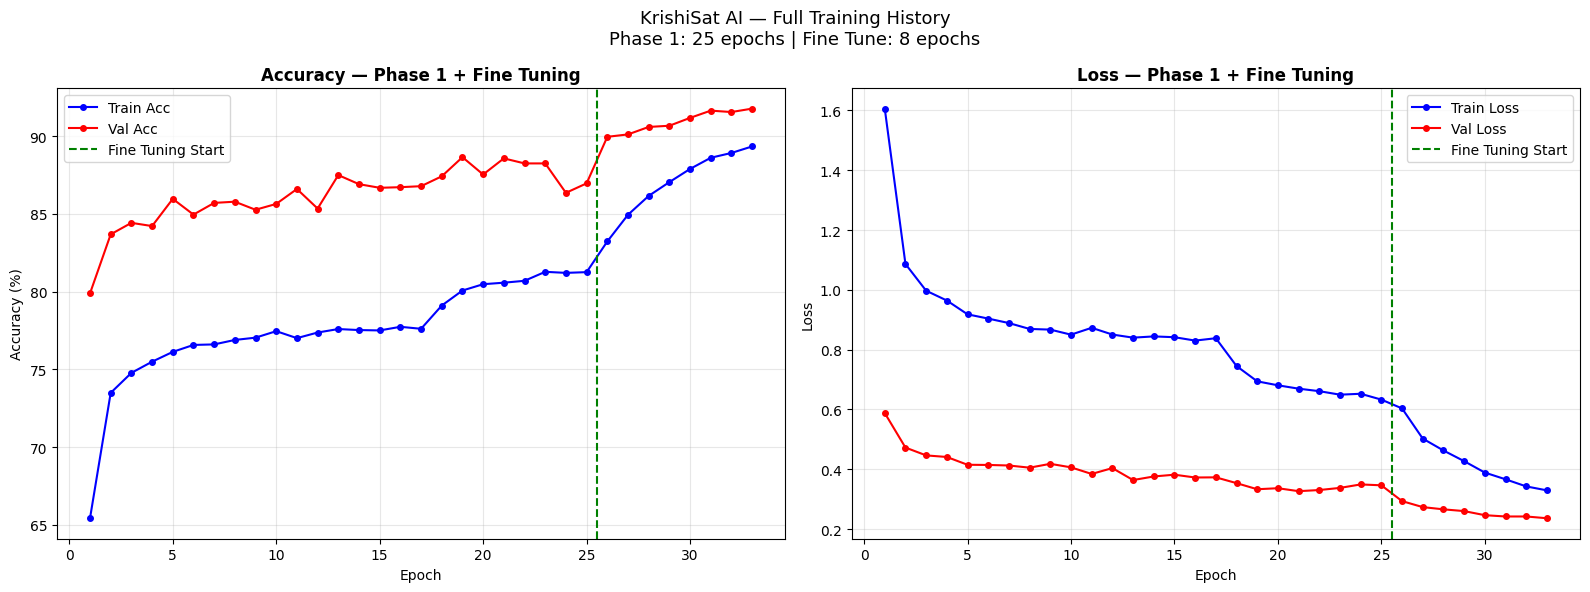

✅ Combined graph saved!

   Phase 1 Best Val Acc   : 88.65%
   Fine Tune Best Val Acc : 91.77%
   Overall Best Val Acc   : 91.77%


In [15]:
# Phase 1 + Phase 2 combined graph
total_epochs_p1 = len(history["train_acc"])
total_epochs_p2 = len(history_ft["train_acc"])

all_train_acc = history["train_acc"]    + history_ft["train_acc"]
all_val_acc   = history["val_acc"]      + history_ft["val_acc"]
all_train_loss= history["train_loss"]   + history_ft["train_loss"]
all_val_loss  = history["val_loss"]     + history_ft["val_loss"]

epochs_range  = range(1, len(all_train_acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax1.plot(epochs_range, all_train_acc, 'b-o', label='Train Acc', markersize=4)
ax1.plot(epochs_range, all_val_acc,   'r-o', label='Val Acc',   markersize=4)
ax1.axvline(
    x=total_epochs_p1 + 0.5,
    color='green', linestyle='--',
    label='Fine Tuning Start'
)
ax1.set_title("Accuracy — Phase 1 + Fine Tuning", fontsize=12, fontweight='bold')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (%)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(epochs_range, all_train_loss, 'b-o', label='Train Loss', markersize=4)
ax2.plot(epochs_range, all_val_loss,   'r-o', label='Val Loss',   markersize=4)
ax2.axvline(
    x=total_epochs_p1 + 0.5,
    color='green', linestyle='--',
    label='Fine Tuning Start'
)
ax2.set_title("Loss — Phase 1 + Fine Tuning", fontsize=12, fontweight='bold')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(
    f"KrishiSat AI — Full Training History\n"
    f"Phase 1: {total_epochs_p1} epochs | Fine Tune: {total_epochs_p2} epochs",
    fontsize=13
)
plt.tight_layout()
plt.savefig("full_training_history.png", dpi=150)
plt.show()

print(f"✅ Combined graph saved!")
print(f"\n   Phase 1 Best Val Acc   : {max(history['val_acc']):.2f}%")
print(f"   Fine Tune Best Val Acc : {max(history_ft['val_acc']):.2f}%")
print(f"   Overall Best Val Acc   : {max(all_val_acc):.2f}%")


In [16]:
# Combined history save
full_history = {
    "phase1": history,
    "phase2": history_ft,
    "combined": {
        "train_acc" : all_train_acc,
        "val_acc"   : all_val_acc,
        "train_loss": all_train_loss,
        "val_loss"  : all_val_loss
    }
}

with open(MODELS_DIR / "full_training_history.json", "w") as f:
    json.dump(full_history, f, indent=2)

# Model info update karo
model_info = {
    "architecture"      : "EfficientNetB0",
    "num_classes"       : NUM_CLASSES,
    "img_size"          : IMG_SIZE,
    "phase1_epochs"     : total_epochs_p1,
    "phase2_epochs"     : total_epochs_p2,
    "phase1_best_acc"   : max(history["val_acc"]),
    "finetune_best_acc" : max(history_ft["val_acc"]),
    "overall_best_acc"  : max(all_val_acc),
    "class_names_file"  : "class_names.json"
}

with open(MODELS_DIR / "model_info.json", "w") as f:
    json.dump(model_info, f, indent=2)

# GPU clear
torch.cuda.empty_cache()

print("✅ Fine Tuning Complete!")
print(f"\n   📁 models/")
print(f"      best_model.pth            ← Best weights overall")
print(f"      class_names.json          ← 96 class names")
print(f"      full_training_history.json← Complete history")
print(f"      model_info.json           ← Updated metadata")
print(f"\n   Next → 04_model_evaluation.ipynb (Day 5)")


✅ Fine Tuning Complete!

   📁 models/
      best_model.pth            ← Best weights overall
      class_names.json          ← 96 class names
      full_training_history.json← Complete history
      model_info.json           ← Updated metadata

   Next → 04_model_evaluation.ipynb (Day 5)
